# Environment Setting

Step 1: upload entire "Structure Product (combined ver.)" folder to google drive\
Step 2: run the first code box below to mount to your google drive\
Step 3: paste the google drive path to "filepath = " below\
Step 4: click "Run all" and find output in "Output.xslx" in google drive\

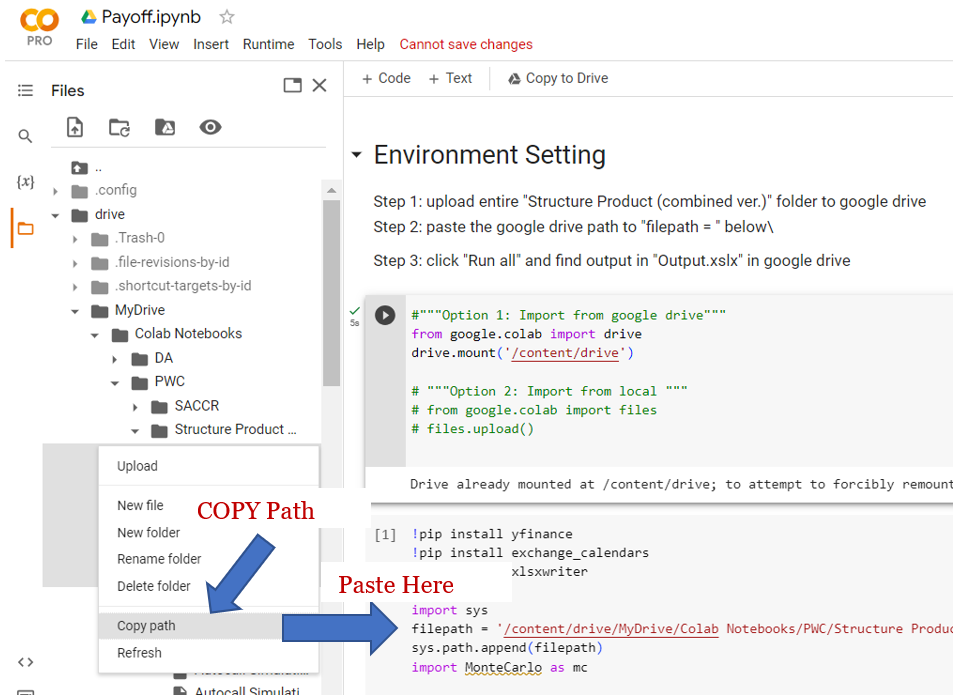

In [1]:

#"""Option 1: Import from google drive"""
### Mount to google drive ###
from google.colab import drive
drive.mount('/content/drive')

# """Option 2: Import from local """
# from google.colab import files
# files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install yfinance
!pip install exchange_calendars
!pip install xlsxwriter

import sys
filepath = '/content/drive/MyDrive/Colab Notebooks/PWC/Structure Product Valuation/Structure Product (separated ver.)/'
sys.path.append(filepath)
import MonteCarlo as mc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 4.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import exchange_calendars as xcals
import datetime as dt
import time
import xlsxwriter
import openpyxl
import random
import os
from openpyxl.drawing.image import Image

#Payoff Calculation

**Call Event:** Occurs when Closing Price of each stock in the Underlying Stock Basket is greater than or equal to its Callable Price on any Call Event Observation Date. When the Call Event occurs, Counterparty will pay BEA, on the Call Event Early Redemption Date any remaining Potential Coupon, which is accrued from and including the previous Coupon Payment Date (or effective date for the first coupon period) to but excluding the Call Event Early Redemption Date.


At maturity, provided that Call Event has never occurred before Determination Date: \
**M1**. If (i) no Kick-in Event has occured; or (ii) a Kick-in Event has occured but the Closing Price of the Worst Performing Stock on the Determination Date is AT or ABOVE its Reference Price, BEA will receive the Annualised Coupon Amount for the final Coupon Period.\
**M2**. If a Kick-in Event has occured and the Closing Price of the Worst Performing Stock on the Determination Date is BELOW its Reference Price, BEA will receive (i) the Annualised Coupon Amount for the final Coupon Period, and (ii) a number of the Worst Performing Stock calculated by reference to its Reference Price on the Maturity Date. (iii) and Fractional Stock in notional currency based on the Closing Price on the Determination Date.


In [4]:
def beld_payoff(info,n_simulation = 100000,rf =.004):
  t0 = time.time()
  # get historical stock prices for simulation
  price_df = mc.get_stock_price(info['tickers'],info['his_data_start'],info['his_data_end'])
  initial_price = mc.get_stock_price(info['tickers'],info['trade_date'],info['trade_date']+dt.timedelta(days=1) )

  # build calender
  xhkg = xcals.get_calendar("XHKG")
  # business date
  bd = xhkg.sessions_in_range(info['trade_date'], info['maturity_date'])
  # business dates in call period
  call_period= xhkg.sessions_in_range(info['call_obs_start'], info['call_obs_end'])

  T = len(bd) #length of simulation
  n_stocks = len(info['tickers'])

  # Run simulation
  rt_0 = time.time()
  simu_df = mc.multi_assets_simulation(T,price_df,rf,n_simulation,initial_price)
  print("Runtime for", n_simulation, "simulations is: ", time.time()-rt_0)

  S0 = simu_df[:,0,0] #initial prices -- array
  call_price = S0 * info['call_rate']  #call barrier prices -- array
  kick_price = S0 * info['kick_rate']  #kick-in barrier prices -- array
  ref_price = S0  * info['ref_rate']   #reference prices -- array

  # Calculate called coupon
  call_coupon_day_count =np.zeros(n_simulation)
  # Store which simulation has not passed call barrier during the call observation period
  no_call = np.ones(n_simulation)

  for n in range(n_simulation):
    for i in call_period:
      idx = bd.get_loc(i)
      # Check if all the underlying stocks crossed call barrier
      exit = np.product(simu_df[:,idx,n] >= call_price)
      if exit:
        # if crossed call barrier -> early redemption -> calculate the coupon_accumulated days
        no_call[n] = 0
        call_coupon_day_count[n] = (i-info['coupon_p1_start']).days #calender days
        break

  # Create arrays to store information about kick-in to calculate payoff
  idx_kick =  [bd.get_loc(info['kick_obs_start']),bd.get_loc(info['kick_obs_end'])]
  kick_obs_df = simu_df[:,idx_kick[0]:idx_kick[1]+1,:]
  no_kick =np.zeros((n_stocks,n_simulation))
  # Determine if stock price in determination day passed reference price
  det_day_df  = simu_df[:,bd.get_loc(info['determination_date']),:]
  pass_ref = np.zeros((n_stocks,n_simulation))
  initial_percentage = np.zeros((n_stocks,n_simulation))

  for i in range(n_stocks):
    # Determine if any kick-in event during kick-in observation period
    no_kick[i]= np.sum(kick_obs_df[i] <= kick_price[i],axis =0) ==0
    # Determine if prices on determination date pass reference price
    pass_ref[i] = det_day_df[i] >= ref_price[i]
    # prices on determination date to reference price for profit and loss calculation
    initial_percentage[i] = det_day_df[i]/S0[i]

  no_kick = np.product(no_kick,axis=0) # no kick-in for all underlying stocks
  pass_ref = np.product(pass_ref,axis=0) # all underlying stocks pass reference
  no_call_no_kick = no_call*no_kick
  no_call_kick = (1-no_kick) * no_call
  no_call_kick_pass_ref = (no_call_kick+pass_ref)==2
  M1 = (no_call_no_kick+no_call_kick_pass_ref)>0
  M2 = no_call_kick* (1-pass_ref)

  #### Calculate Payoff ####
  day_count_basis = info['day_count_basis']
  coupon_rate = info['coupon_rate']
  deposit_amount = info['deposit_amount']

  # Payoffs for call event
  call_payoff = call_coupon_day_count/day_count_basis * coupon_rate*deposit_amount\
   * mc.discount_rate(call_coupon_day_count,rf,day_count_basis)

  # Payoffs for M1 event (See definition listed above)
  maturity_coupon_day_count = (info['coupon_p2_end'] - info['coupon_p1_start']).days
  M1_payoff = M1 * maturity_coupon_day_count/day_count_basis * coupon_rate * deposit_amount\
    *mc.discount_rate(maturity_coupon_day_count,rf,day_count_basis)

  # Payoffs for M2 event (See definition listed above)
  M2_loss = M2 * deposit_amount*(1-np.min(initial_percentage,axis = 0))\
    *mc.discount_rate(maturity_coupon_day_count,rf,day_count_basis)
  M2_payoff = M2 * (maturity_coupon_day_count/day_count_basis * coupon_rate * deposit_amount )\
    *mc.discount_rate(maturity_coupon_day_count,rf,day_count_basis)

  pay_counter_date_count = call_coupon_day_count + maturity_coupon_day_count *(M1+M2)
  pay_counterparty =  pay_counter_date_count/day_count_basis * info['HIBOR'] *deposit_amount\
      *mc.discount_rate(pay_counter_date_count,rf,day_count_basis)

  coupon_earning = call_payoff + M1_payoff + M2_payoff
  pnl =  coupon_earning - pay_counterparty - M2_loss

  print("Total Runtime：", time.time()-t0)
  return coupon_earning, pnl, simu_df,price_df


# Write Output

In [5]:
def write_output(info, coupon_earning, pnl, simu_df,his_price, n_simulation,output_file):
  # write evaluation results to output file
  deposit_amount = info['deposit_amount']
  output_df = pd.DataFrame(columns = ['A'])

  output_df.loc['tickers'] = [info['tickers']]
  output_df.loc['referencing period'] = info['his_data_start'].strftime("%m/%d/%Y")+"-"+info['his_data_end'].strftime("%m/%d/%Y")
  output_df.loc['deposit amount'] = info['deposit_amount']
  output_df.loc['simulation'] = n_simulation
  output_df.loc['potential payoff'] = np.mean(coupon_earning)
  output_df.loc['potential P&L'] = np.mean(pnl)
  output_df.loc['maximum loss'] = np.min(pnl)
  output_df.loc['maximum profit'] = np.max(pnl)
  output_df['B'] = [" "]*4+(output_df.iloc[4:,0].values/deposit_amount).tolist()

  # print plot
  plt.figure(figsize=(10,9))
  plt.subplot(2,2,1)
  mc.print_stock_plot(info['tickers'],his_price,"Historical Stock Path")
  plt.xticks(rotation = 15)
  plt.subplot(2,2,2)
  plt.hist(coupon_earning)
  plt.gca().set(title='Coupon Earning Frequency Histogram', ylabel='Frequency',xlabel='Coupon Earning');
  plt.subplot(2,2,3)
  plt.hist(pnl[pnl<=0])
  plt.gca().set(title='Loss Frequency Histogram', ylabel='Frequency',xlabel='Total Loss');
  plt.subplot(2,2,4)
  plt.hist(pnl[pnl>0])
  plt.gca().set(title='Profit Frequency Histogram', ylabel='Frequency',xlabel='Total Profit');
  p1 = plt.savefig("myplot.png", dpi = 60)

  # print randomly selected simulated paths
  # call_price = simu_df[0,0,0] * info['call_rate']
  # kick_price = simu_df[0,0,0] * info['kick_rate']
  # ref_price = simu_df[0,0,0] * info['ref_rate']

  plt.figure(figsize=(10,9))
  random_path = random.sample(range(n_simulation),4)
  for i in range(4):
    plt.subplot(2,2,i+1)
    mc.print_stock_plot(info['tickers'],simu_df[:,:,random_path[i]].T,\
                        "Randomly Selected Paths: No."+str(random_path[i]))#,\
                        # hori_line = [call_price,kick_price,ref_price],\
                        # hori_label = ['call barrier','kick barrier', 'reference price'])
  p2 = plt.savefig("myplot2.png", dpi = 60)
  p1 = Image("myplot.png")
  p2 = Image("myplot2.png")

  return output_df,p1,p2

# Run Inputted Contract

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Runtime for 100000 simulations is:  13.42816948890686
Total Runtime： 55.90886878967285
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Runtime for 100000 simulations is:  11.835496187210083
Total Runtime： 39.537574768066406
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 comple

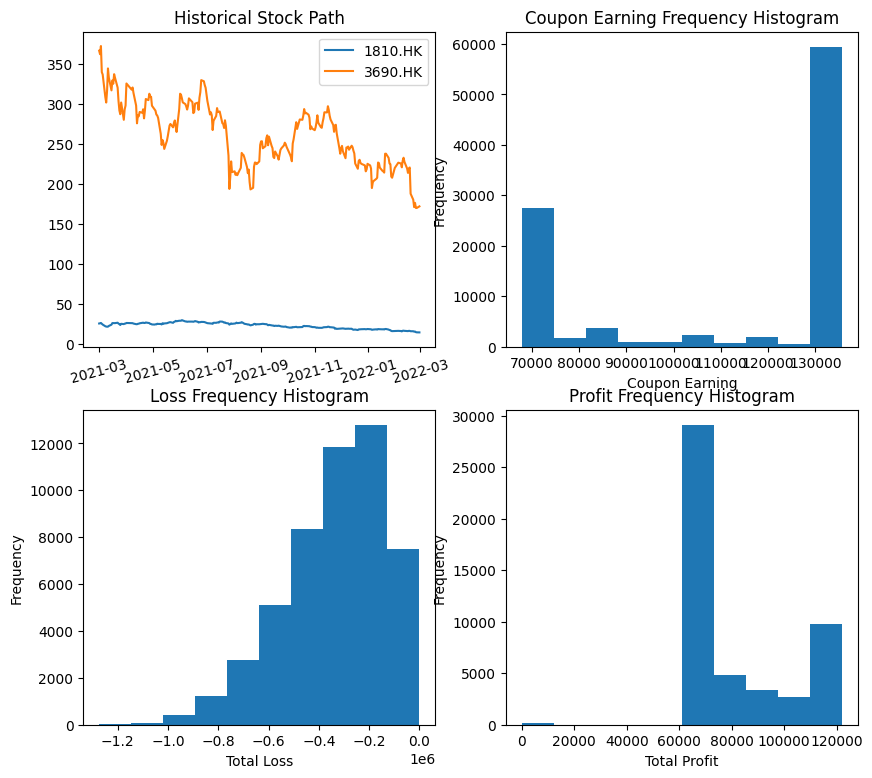

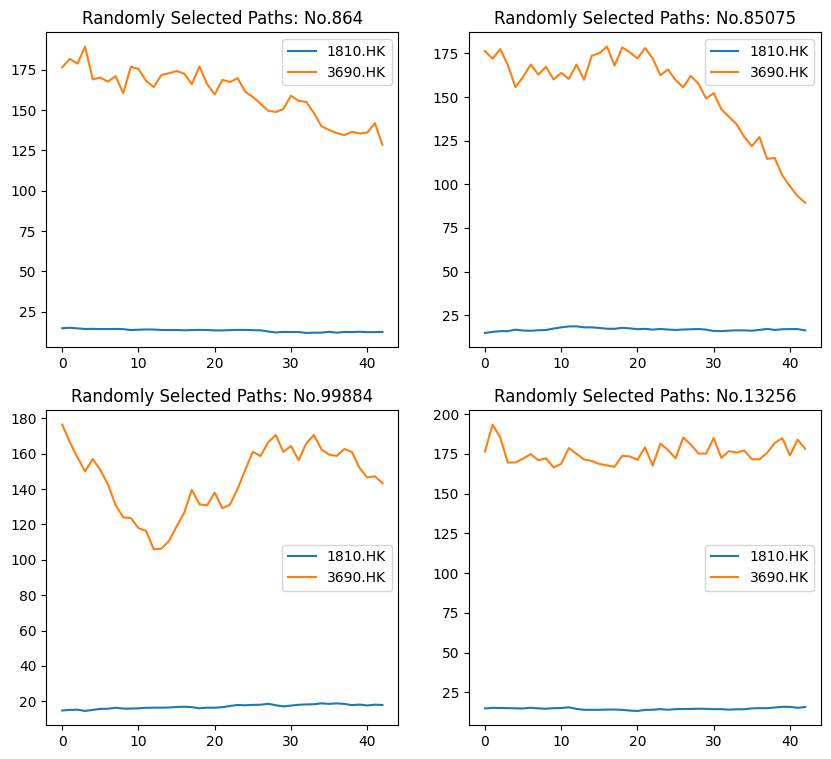

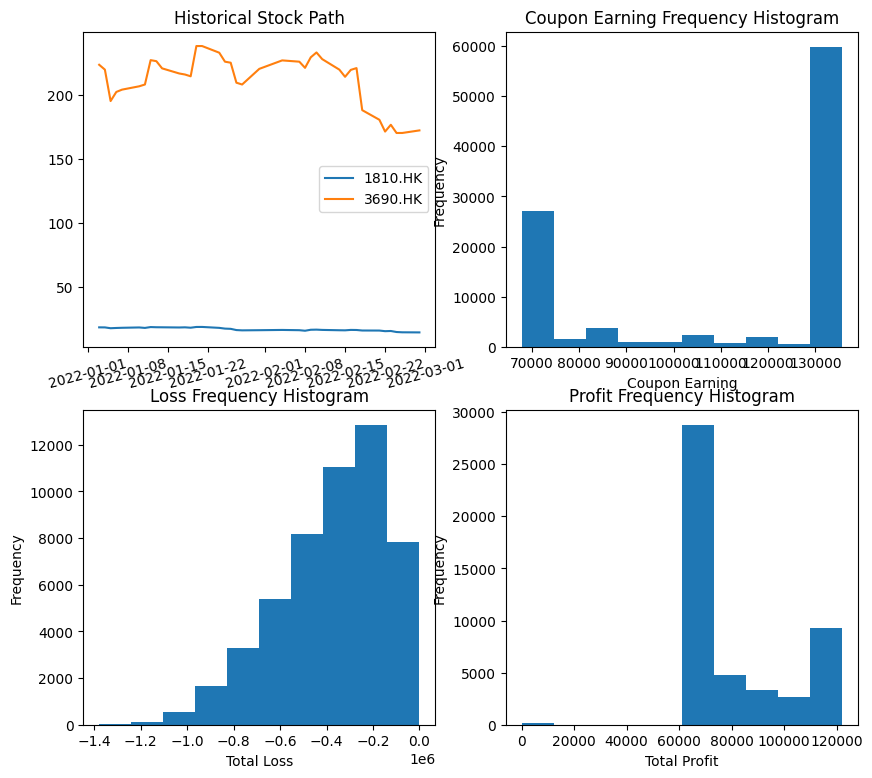

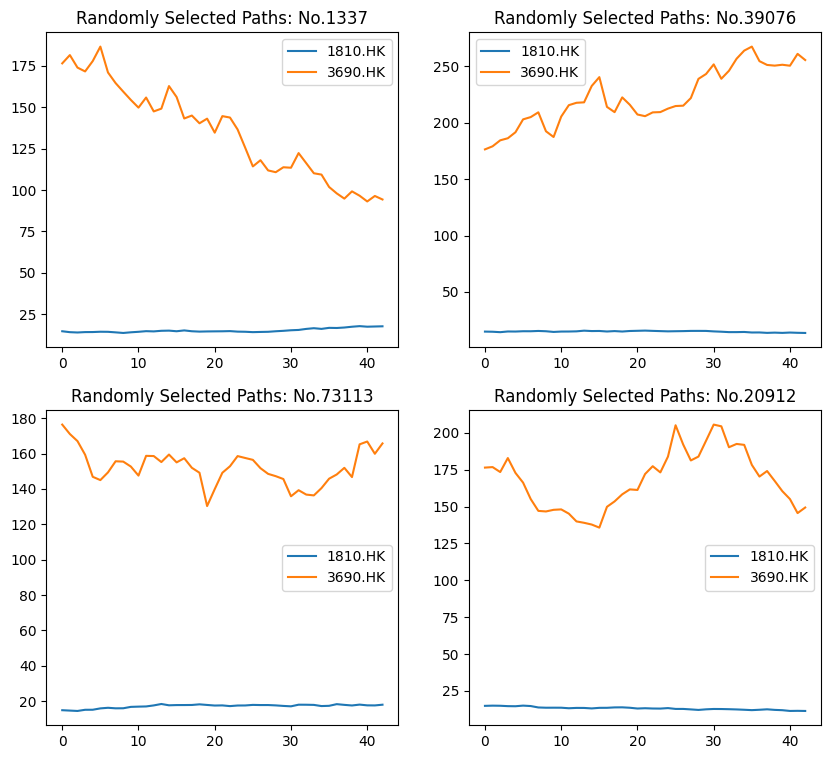

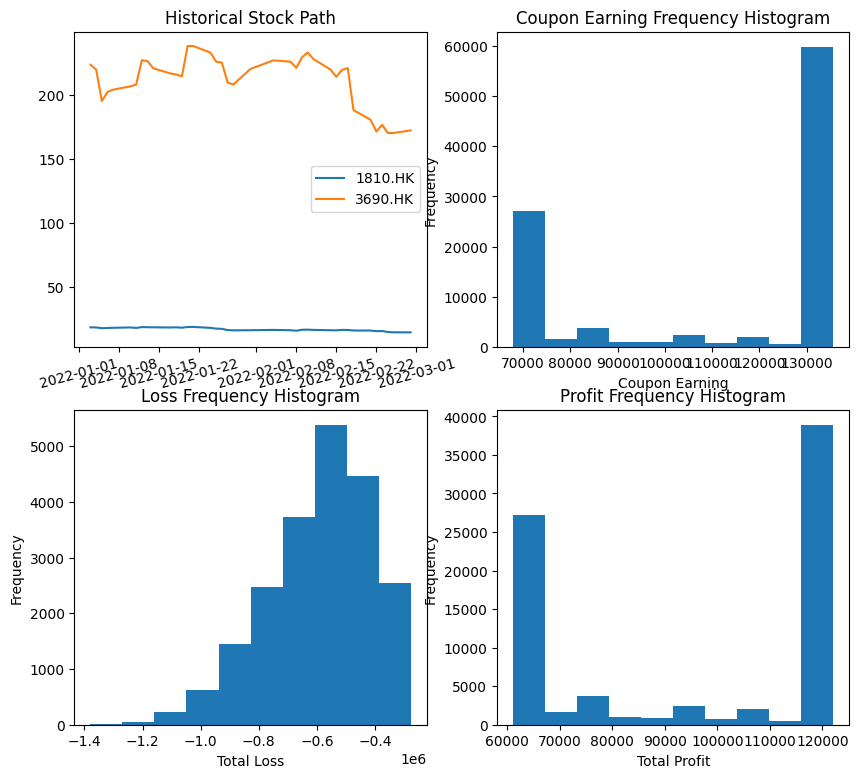

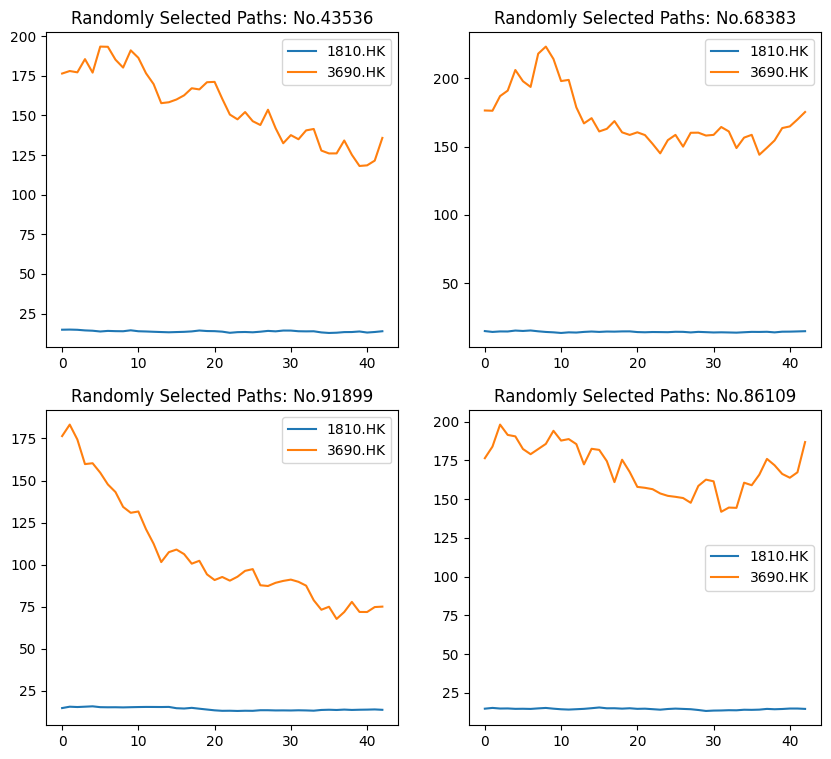

In [6]:
contract_df = pd.read_excel(filepath+'Input.xlsx',sheet_name='Basket_Equity_Linked_Deposit')
contract = contract_df.to_dict('records')
n_record = len(contract)

# Create output file if it is not in the path
output_filepath = filepath + 'Output.xlsx'
if not os.path.isfile(output_filepath):
  wb = openpyxl.Workbook()
  wb.save(output_filepath)

# Loop over all contracts
for i in range(n_record):
  contract[i]['tickers'] = contract[i]['tickers'].split(',')
  n_simulation,rf = contract[i]['n_simulation'],contract[i]['risk_free']

  # Run simulation for each contracts
  coupon_earning, pnl, simu_df,his_price = beld_payoff(contract[i],n_simulation,rf)

  output_df,p1,p2 = write_output(contract[i], coupon_earning, pnl, simu_df,\
                                his_price,n_simulation, output_filepath)

  # Load workbook and write result
  wb = openpyxl.load_workbook(output_filepath)
  sheet_name = contract[i]['contract']
  try:
    ws = wb[sheet_name]
  except KeyError:
    ws = wb.create_sheet(sheet_name)

  ws.add_image(p1,'E1')
  ws.add_image(p2,'E30')

  ws.column_dimensions['A'].width = 20
  ws.column_dimensions['B'].width = 20
  ws.column_dimensions['C'].width = 20

  wb.save(output_filepath)

  with pd.ExcelWriter(output_filepath, engine = 'openpyxl',mode="a",if_sheet_exists="overlay") as writer:
    output_df.to_excel(writer,sheet_name = contract[i]['contract'])

